# Perform the event segmentation analyses for movie data

This notebook performs event segmentation analyses on movie watching data and recreates figures in the manuscript. It uses event segmentation files created from various scripts as described in the README and preprocessed movie data, assumed to be saved in `data/EventSeg/`. If re-running the cells in [Create input data](#preproc), you must also have downloaded the nifti files for the movie data, assumed to be saved in `data/Movies/`.

Note: p values may differ from those reported in the manuscript because of random seeds. If rerunning event segmentation scripts, z-statistic values may also slightly vary for the same reason.

**Table of Contents**
>[Set up](#setup)  
>[Participant summary information](#descriptives)    
>[Create input data](#preproc)      
>[Intersubject correlation analyses](#isc)  
>[Optimal number of events](#optimalk)  
>[Reliable event structure in ROIs](#nested)  
>[Event structure across age groups](#across)  
>[Behavioral boundary analyses](#behavbound)  

## Set up <a id='setup'></a>

In [1]:
%matplotlib inline
%autosave 5

# suppress warning
import warnings 
warnings.filterwarnings('ignore')

# Import a bunch of stuff 
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
import numpy as np
import pandas as pd
import sys
import os
import scipy.stats as stats
from scipy.stats import norm, zscore, pearsonr, ttest_ind
from scipy.signal import gaussian, convolve
from scipy.spatial.distance import squareform
from sklearn import decomposition, preprocessing
from sklearn.model_selection import LeaveOneOut, RepeatedKFold
import seaborn as sns
import itertools
import nibabel as nib
from nilearn.input_data import NiftiMasker
from nilearn import plotting

# Modified event segmentation and isc brainiak scripts for infant data
import event_seg_edits.Event_Segmentation as EventSegment
from event_seg_edits.modified_isc import *

Autosaving every 5 seconds


In [2]:
# Choose the movie! 
movie = 'Aeronaut' # name used for the main Aeronaut dataset
#movie = 'Mickey' # name used for the secondary Mickey dataset

print('Running analyses on:',movie)

# Set up some movie specific stuff 
if movie == 'Aeronaut':
    nTRs=90
    nSubj=24 
    num_events=np.arange(2,22) # you can change the max number of events in your own analyses 
    mask = 'intersect_mask_standard_firstview_all' # intersect mask name
    average_halves = 0 # participants only watched the movie once
    
elif movie == 'Mickey':
    nTRs=71
    nSubj=15
    num_events=np.arange(2,19) # you can change the max number of events in your own analyses 
    mask = 'intersect_mask_standard_all' # intersect mask name
    average_halves = 1 # we are going to average across both viewings
    print('If movie was seen twice, averaging data across viewings')

#  Variables for plotting whole brain stuff
isc_thresh=0.1 # what isc threshold do you want to use?
vmax=0.4 # what is the maximum ISC on the color bar?
cmap='cold_hot'
cut_coords=(2,-80,-5)
    
# Get the base directory
curr_dir = os.getcwd()
os.chdir('../../') # Move into the infant neuropipe root
base_dir = os.getcwd() + '/'
os.chdir(curr_dir) # Come back

# Set the event segmentation directories
roi_dir =  base_dir + 'data/EventSeg/ROIs/' 
movie_eventseg_dir =  base_dir + 'data/EventSeg/%s/' % movie
searchlight_dir = movie_eventseg_dir + 'eventseg_searchlights/'
optk_dir = movie_eventseg_dir +'eventseg_optk/'
human_dir = movie_eventseg_dir + 'eventseg_human_bounds/'
save_plot_dir = movie_eventseg_dir+'plots/' 

# Set the movie data directories
alignment='linear_alignment' # choose linear alignment for main analyses
preprocessed_dir = base_dir + 'data/Movies/%s/preprocessed_standard/%s/' % (movie,alignment)
eye_dir = base_dir + 'data/Movies/%s/eye_confounds/' % movie
motion_dir = base_dir + 'data/Movies/%s/motion_confounds/' % movie

# Set up the ROIs
rois=['EVC_standard','LOC_standard','AG_standard','PCC_standard','Precuneus_standard',
      'mPFC_standard','Hippocampus_standard','EAC_standard']

roi_short=np.array([r.split('_')[0] for r in rois])
roi_short[np.where(roi_short=='Precuneus')]='Prec'
roi_short[np.where(roi_short=='Hippocampus')]='Hipp'

colors=sns.color_palette("husl",len(rois))

# Get the brain mask    
brain_nii=nib.load(movie_eventseg_dir+mask+'.nii.gz')

brain_masker=NiftiMasker(mask_img=brain_nii)

test_sub=nib.load(movie_eventseg_dir+mask+'.nii.gz') 
test_fit=brain_masker.fit(test_sub)
affine_mat = test_sub.affine
dimsize = test_sub.header.get_zooms()
coords= np.where(brain_nii.get_data())

Running analyses on: Aeronaut


### Functions 
Define a bunch of functions that will be used in this notebook

In [3]:
def confound_TR_vec(confound_file, closed_file, vec_length, which_half = 1, eye_shift=2):
    ''''Create a vector of TRs to be excluded for this half of the movie'''
    
    # "Load in the confound file and find the columns that have a value of 1 in them
    if confound_file is not '':
        confound_data = np.loadtxt(confound_file, unpack=False, dtype=float)
        confound_idxs = np.where(confound_data==1)[0]

        # Do you want to exclude epochs where their eyes are closed
        if closed_file is not '':

            # Load in the data                        
            closed_data = np.loadtxt(closed_file, delimiter=" ", unpack=False)
            
            # What TRs are excluded
            closed_eyes = np.where(closed_data==1)[0] + eye_shift # shift the eye tracking data
            
            # Update the confound idxs to be excluded
            confound_idxs = np.unique(np.append(confound_idxs, closed_eyes))
            
    else:
        confound_idxs = np.array([])

    # Preprocess the data
    if len(confound_idxs) > 0:

        # If it is not the first half then realign
        if which_half == 2:
            # Remove all indexes from the first half
            confound_idxs -= confound_data.shape[0] // 2
            confound_idxs = confound_idxs[confound_idxs >= 0]

        # Bound the excluded TRs that are outside of the shape
        confound_idxs = confound_idxs[confound_idxs < vec_length]
        
        # Remove any that are under 0 for any reason
        confound_idxs = confound_idxs[confound_idxs >= 0]
        
    ppt_name = confound_file[confound_file.rfind('/') + 1:confound_file.rfind('.')]
    print('%s has %d %% of TRs excluded' % (ppt_name,(len(confound_idxs)/nTRs)*100)) #, confound_idxs)
    
    return confound_idxs

def brain_2_vec(data, mask, confound_idxs=None):
    '''Make a vector average from brain data'''
    # Take in data that is 4d and mask that is 4d. Confound idxs is a list of time points that are to be excluded
    
    # Pull out the data
    masked_data = data[mask == 1]
    masked_data = masked_data.reshape((int(mask.sum()), data.shape[3]))
    
    # Average the activity across voxels
    brain_vec = np.mean(masked_data, 0).flatten()
    
    # Turn the timepoints that aren't included into nan's
    if confound_idxs is not None:
        brain_vec[confound_idxs] = np.nan
    
    # Return the vector map
    return brain_vec, masked_data

def preprocess_data(sub,average_halves):
    '''Preprocess movie data by excluding TRs for motion and eye tracking, averaging across within-session viewings if desired'''
    sub_nifti = nib.load(preprocessed_dir + sub + '_Z.nii.gz').get_data()
    sub_motion_confound = motion_dir + sub + '.txt'
    sub_eye_confound = eye_dir + sub + '.txt'
    
    if average_halves==1:
        ## First viewing
        print('First viewing')
        # get the confounds
        confound_idxs = confound_TR_vec(sub_motion_confound, sub_eye_confound, nTRs, which_half=1)

        # get half the data
        half_tr = sub_nifti.shape[3] // 2 
        temp_vol = sub_nifti[:, :, :, :half_tr-3] # cut off the last 3 TRs
       
        # mask the data
        brain_vec, brain_masked = brain_2_vec(temp_vol, brain_nii.get_data(), confound_idxs)

        brain_masked=brain_masked.T # transpose to be TR x vox
        brain_masked[np.isnan(brain_vec),:]=np.nan # fill nans as needed

         ## Second viewing
        # Is there at least two runs?
        if np.abs(sub_nifti[:, :, :, half_tr:]).sum() > 0:
            print('Second viewing')
            
            # get half the data
            temp_vol2 = sub_nifti[:, :, :, half_tr:-3] # cut off the last 3 TRs

            # Pull out the TRs that are not useable
            confound_idxs2 =confound_TR_vec(sub_motion_confound, sub_eye_confound, nTRs, which_half=2)

            brain_vec2, brain_masked2 = brain_2_vec(temp_vol2,  brain_nii.get_data(), confound_idxs2)

            brain_masked2=brain_masked2.T # transpose to be TR x vox
            brain_masked2[np.isnan(brain_vec2),:]=np.nan # fill nans as needed

            brain_masked=np.nanmean(np.stack((brain_masked,brain_masked2)),axis=0)
    else:
        # get the confounds
        confound_idxs = confound_TR_vec(sub_motion_confound, sub_eye_confound, nTRs)

        # shift the data
        length=sub_nifti.shape[3]-3 # cut off the last 3 TRs
        temp_vol = sub_nifti[:, :, :, :length]

        # mask the data
        brain_vec, brain_masked = brain_2_vec(temp_vol, brain_nii.get_data(), confound_idxs)

        brain_masked=brain_masked.T # transpose to be TR x vox
        brain_masked[np.isnan(brain_vec),:]=np.nan # fill nans as needed
        
    return brain_masked

def mask_roi_data(wholebrain_data,roi):
    '''Mask whole brain data using a given ROI'''
    roi_data=[]
    for sub in range(wholebrain_data.shape[2]):

        roi_nii=nib.load(roi_dir+roi+'.nii.gz')

        sub_nii=brain_masker.inverse_transform(wholebrain_data[:,:,sub])

        sub_data=sub_nii.get_data()[np.array(brain_nii.get_data()*roi_nii.get_data(),dtype=bool)]
        roi_data.append(sub_data)
    
    roi_data=np.stack(roi_data)
    return roi_data

def get_bestk_roi(age,roi,num_events,split=2):
    '''Pull the numpy file that has information on the best K and maximum log likelihood for a given age group
    the split variable tells you how the data was divided during the inner loop training (we used split half, so
    defaults to a split value of 2)'''
    all_ll_loops=np.zeros((len(num_events),nSubj//split*split))

    for n in range(len(num_events)):
        loglik=np.load('%s/%s_%s_%d_events_cb_method_loglik_%d.npy' % (optk_dir,age,roi,num_events[n],split))
        all_ll_loops[n,:]=loglik

    mean_ll=np.nanmean(all_ll_loops,axis=1)
    ll_idx=np.argmax(mean_ll)
    bestk=np.array(num_events)[ll_idx]
    
    return bestk

def optk_results(optk_dir,age,roi,nSubj):
    '''Load the reliability results from the nested cross validation analysis'''
    kvals=[]
    logliks=[]
    zstats=[]
    for i in range(nSubj):
        kval, loglik, zstat=np.load(movie_eventseg_dir+'/eventseg_optk/%s_%s_relsub_%d_bestk_loglik.npy' % (age,roi,i))
        kvals.append(kval)
        logliks.append(loglik)
        zstats.append(zstat)
    
    return np.array(kval),np.array(logliks), np.array(zstats)
  
def create_roll(data,determined_shift=None):
    '''Shifts data either a random value (when determined_shift: 'None') or shifts the given amount'''
    rolled_data=data.copy()
    for sub in range(len(data)):
        if determined_shift==None:
            shift=np.random.randint(1,data.shape[1])
        else:
            shift=determined_shift
        #print('sub: %d shift: %d' %(sub,shift))

        rolled_data[sub,:,:]=(np.roll(data[sub,:,:],shift,axis=1))
        
    return rolled_data

def bootstrap_mean(data,null_vall=0,nPerm=1000):
    '''Bootstrap resampling for the mean of the data'''
    perm_dist=[]
    for perm in range(nPerm):
        sampidx=np.random.choice(np.arange(len(data)),len(data),replace=True)
        randomsamp=np.array(data)[sampidx]
        perm_dist.append(np.nanmean(randomsamp))
    
    # calculate 2 way pval
    if np.nanmean(data) < null_vall:
        pval=np.sum(np.array(perm_dist)>null_vall)/nPerm*2
    else:
        pval=np.sum(np.array(perm_dist)<null_vall)/nPerm*2
        
    # If the value is greater than 1 then subtract 2
    if pval > 1:
        pval = 2 - pval
    
    CIs =[np.percentile(perm_dist, 2.5), np.percentile(perm_dist, 97.5)]
          
    return pval, CIs

def bootstrap_corr(x_data,y_data,nPerm=1000):
    '''Bootstrap resampling for the correlation between two variables'''
    
    corr_dist=[]
    
    # Occasionally may have NaNs so need to leave them out if true
    if sum(np.isnan(np.array(x_data))) > 0:
        print('X data contains %s NaNs' %(sum(np.isnan(np.array(x_data)))))
    if sum(np.isnan(np.array(y_data))) > 0:
        print('Y data contains %s NaNs' %(sum(np.isnan(np.array(y_data)))))       
    
    not_nan=np.where(~np.isnan(np.array(x_data))*~np.isnan(np.array(y_data)))[0]
    x_data=np.array(x_data)[not_nan]
    y_data=np.array(y_data)[not_nan]
    
    for perm in range(nPerm):
        sampidx=np.random.choice(np.arange(x_data.shape[0]),x_data.shape[0],replace=True)
        random_x=np.array(x_data)[sampidx]
        random_y=np.array(y_data)[sampidx]
        rval, pval=pearsonr(random_x,random_y)
        corr_dist.append(rval)
    
    # calculate 2 way pval
    if stats.pearsonr(x_data,y_data)[0] < 0:
        pval=np.sum(np.array(corr_dist)>=0)/nPerm*2
    else:
        pval=np.sum(np.array(corr_dist)<=0)/nPerm*2
        
    # If the value is greater than 1 then subtract 2
    if pval > 1:
        pval = 2 - pval
        
    CIs =[np.percentile(corr_dist, 2.5), np.percentile(corr_dist, 97.5)]
          
    return pval, CIs

def randomise_diff_2sample(data_1, data_2, resample_num=1000):        
    '''Bootstrap resampling independent samples. 
    Take N samples with replacement from each group separately, average within group and then subtract. 
    Do this X times and report the p value of the number of samples in the opposite direction 
    from the true effect'''
    
    # Resample the participants
    resample_diff = []
    for i in range(resample_num):
        
        # Determine what participants to use in the sample
        sub_idx_1 = np.random.randint(0, len(data_1), (1, len(data_1)))
        
        sub_idx_2 = np.random.randint(0, len(data_2), (1, len(data_2)))

        resample_diff += [np.mean(data_1[sub_idx_1]) - np.mean(data_2[sub_idx_2])]
    
    # calculate the 2 way p value
    p_val = (1 - ((np.sum(np.asarray(resample_diff) > 0)) / (resample_num))) * 2
    
    # If the value is greater than 1 then subtract 2
    if p_val > 1:
        p_val = 2 - p_val
    
    CIs =[np.percentile(resample_diff, 2.5), np.percentile(resample_diff, 97.5)]
    
    mean_diff = np.mean(data_1) - np.mean(data_2)
    
    # return the difference in ROI and 
    return p_val, mean_diff, CIs

def draw_sig(pval,num_comp,xpos,ypos,subplot=False):
    '''Draw significance stars on a plot given the pval, number of comparisons and x and y positions'''
    if pval<0.001/num_comp:
        text='***'
    elif pval<0.01/num_comp:
        text='**'
    elif pval<0.05/num_comp:
        text='*'
    elif pval<0.1/num_comp:
        text='~'
    else:
        text=''
    
    if subplot==False:
        plt.annotate(text,(xpos,ypos),fontsize=14)
    else:
        subplot.annotate(text,(xpos,ypos),fontsize=14)

def searchlight_optk_data(age,nSubj,num_events,split):
    '''Load the different nifti files for iterations of the searchlight optimal K and 
    then calculate the whole brain nifti file with best K values'''
    
    all_high_lls=[]

    for n in num_events:
        data=[]
        for leftout_sub in range(nSubj//split*split):
            
            # Load in all the data for the different iterations and number of events  
            num_data_nii=nib.load('%s/%s_all_events_%s_iter_%d_lls.nii.gz' % (searchlight_dir,age,n,leftout_sub))
            num_data=brain_masker.fit_transform(num_data_nii)

            data.append(num_data[0])

        data=np.stack(data)
        all_high_lls.append(np.nanmean(data,axis=0))

    ll_stack=np.stack(all_high_lls)

    #Now which one had the best k?
    best_k=np.zeros(ll_stack.shape[1])

    for vox in range(ll_stack.shape[1]):
        best_ll=np.nanargmax(ll_stack[:,vox])
        best_k[vox]=num_events[best_ll]
    
    return best_k

def gethumanbounds():
    '''Get the human-determined behavioral boundaries for this movie (already shifted and aligned to TRs) 
    and return different forms of the data useful for running behavioral analyses'''
    # import the human labeled events
    humanlab_events_TR=np.load(movie_eventseg_dir+'behavioral_boundary_events.npy')
    num_events = (len(humanlab_events_TR[0])+1) #length of events
    #print('Number of human labeled events:',num_events)

    # Create an array of length nTRs that tells you whether event is a human labeled event
    events_fullarray = []
    event_idx = humanlab_events_TR[0]
    for idx in range(num_events):
        if idx == 0:
            nums = np.repeat(idx,event_idx[idx])
        elif idx == len(humanlab_events_TR[0]):
            nums = np.repeat(len(humanlab_events_TR[0]),(90 - event_idx[idx-1]))
        else:
            nums = np.repeat(idx,(event_idx[idx] - event_idx[idx-1]))
        events_fullarray.extend(nums) 
    #print('Events:',events_fullarray)
    #print(len(events_fullarray))

    return humanlab_events_TR[0], events_fullarray

def humanbounds_eventmat():
    '''Create a matrix showing which timepoint pairs are within events, and the distance of these pairs from the diagonal'''
    bounds_TR, events_array = gethumanbounds()
    
    ## Step 1 -- make the matrices that tell you about distance and event status
    #add 0 and the end of the movie 
    event_aug = np.concatenate(([0],np.array(bounds_TR),[len(events_array)])) 

    #now create a matrix the same size as the data but with 1 for event 0 for outside-event
    event_mat = np.ones([len(events_array),len(events_array)])

    #fill it up
    for bound in range(len(event_aug)):
        if bound <= len(bounds_TR):
            bound=np.int(bound)
            event_mat[np.int(event_aug[bound]):np.int(event_aug[bound+1]),
                    np.int(event_aug[bound]):np.int(event_aug[bound+1])] = 2
  
    dist_mat = np.zeros([len(events_array),len(events_array)])

    #fill it up
    for time in range(len(events_array)):
        for othertime in range(len(events_array)):
            dist_mat[time,othertime] = np.abs(othertime-time)

    return event_mat, dist_mat 

def human_boundary_analysis(data):
    '''Find the within-vs-across behavioral boundary correlations after accounting for distance to the diagonal
    resamples correlations in the case of unbalanced distributions'''
    
    ## Step 1 -- make the matrices that tell you about distance and event status
    
    event_mat, dist_mat = humanbounds_eventmat()
    
    ## Step 2 -- run through the data 
    
    wvas=[]
    wvas2=[]
    for sub in range(len(data)):
        
        # First, let's find the correlation matrix
        corr_mat=np.corrcoef(data[sub].T)
      
        # Where are the non events?? 
        event_mask=event_mat==2
        nonevent_mask=event_mat==1

        # What about the nans?
        non_nan_times=~np.isnan(corr_mat)

        possible_distances=np.unique(dist_mat[event_mat==2])

        differences=[]
        weights=[]
        nPerm=1000
        for dist in possible_distances:
            dist_mask=dist_mat==dist

            # mask out the nans and only look at the pairs a distance away
            dist_event_mask=event_mask*dist_mask*non_nan_times
            dist_nonevent_mask=nonevent_mask*dist_mask*non_nan_times

            corr_evs=corr_mat[dist_event_mask] # get the correlation here if its an event
            corr_nonevs=corr_mat[dist_nonevent_mask]  # get the correlation here if its not an event 

            # preset 
            perms=np.zeros(nPerm)

            # permute the one that is larger 
            if len(corr_evs) > len(corr_nonevs):
                sub_group=corr_evs
            else:   
                sub_group=corr_nonevs

            # permute! 
            for perm in range(nPerm):        
                subsamp=np.random.choice(sub_group,size=len(sub_group))       
                perms[perm]=np.nanmean(subsamp,axis=0)

            # subtract within event - between event
            if len(corr_evs) > len(corr_nonevs):
                wva_dist=np.nanmean(perms)-np.nanmean(corr_nonevs)
                weight=len(corr_nonevs)
            else:   
                wva_dist=np.nanmean(corr_evs)-np.nanmean(perms)
                weight=len(corr_evs)

            # append the distances 
            differences.append(wva_dist)
            weights.append(weight)
            
        wvas.append(np.nanmean(differences))
                
        weighted_differences=np.nansum([differences[i]*weights[i] for i in np.arange(len(differences))])/np.nansum(weights)
        wvas2.append(weighted_differences)
        
    return wvas, wvas2

def human_boundary_analysis_alt(data):
    '''Find the within-vs-across behavioral boundary correlations for each TR and distance to the diagonal if forward and
    backward timepoint pairs differ in whether they are within vs across an event'''
    ## Step 1 -- make the matrices that tell you about distance and event status
    
    event_mat, dist_mat = humanbounds_eventmat()
    
    ## Step 2 -- run through the data 
    
    wvas=[]
    
    for sub in range(len(data)):
        corr_mat=np.corrcoef(data[sub].T)
        
        # First, let's find the correlation matrix     
        withins=[]
        acrosses=[]
        used_mat=np.zeros(corr_mat.shape) 
        for TR in range(corr_mat.shape[0]):
            #print('TR!',TR)
            for dist in range(corr_mat.shape[0]): # will break before it gets to this distance anyways
                #print('dist',dist)
                if TR+dist<corr_mat.shape[0] and TR-dist>0: # don't look too far forward is back
                    forward_pair=event_mat[TR+dist,TR]
                    backward_pair=event_mat[TR,TR-dist]
                    #print(forward_pair,backward_pair)

                    # if one of these comparisons is within event and the other is across, we continue
                    # also make sure no nans in either pair, and that these timepoints have not been used before 
                    if forward_pair!=backward_pair and ~np.isnan(corr_mat[TR+dist,TR]) and ~np.isnan(corr_mat[TR,TR-dist]) and used_mat[TR,TR-dist]==0 and used_mat[TR+dist,TR]==0:

                        if forward_pair>backward_pair: # forward is the within event
                            within=corr_mat[TR+dist,TR]
                            across=corr_mat[TR,TR-dist]

                        elif forward_pair<backward_pair: # backward is the within event
                            within=corr_mat[TR,TR-dist]
                            across=corr_mat[TR+dist,TR]
                        
                        used_mat[TR,TR-dist]+=1 # indicate that you've used this timepoint before
                        used_mat[TR+dist,TR]+=1
                        
                        withins.append(within)
                        acrosses.append(across)
                        
        wvas.append(np.nanmean(withins) - np.nanmean(acrosses))
                        
    return wvas

## Participant summary information <a id='descriptives'></a>

Infant participants

In [4]:
# Load in the data
df = pd.read_csv(movie_eventseg_dir + '/infant_participants.csv')
df

,ppt,age,sex,location,session_number,num_TR,prop_TR_motion,prop_TR_eye,eye_reliability,coder_num
0,s0057_1_3,9.0,F,BIC,1,90,1.000000,0.955556,0.953125,2
1,s0607_1_2,12.7,M,BIC,1,90,1.000000,0.977778,0.918173,2
2,s1607_1_2,10.7,M,BIC,1,90,0.955556,0.844444,0.930992,2
3,s2037_1_1,5.6,M,BIC,1,90,0.944444,0.800000,0.777226,2
4,s2047_1_1,4.7,M,BIC,1,90,0.933333,0.888889,0.957358,2
5,s2057_1_2,7.7,F,BIC,1,90,0.966667,0.811111,0.916482,2
6,s2067_1_1,4.2,M,BIC,1,90,0.944444,0.955556,0.914984,2
7,s2097_1_1,5.2,M,BIC,1,90,0.866667,0.944444,0.971381,2
8,s2687_1_3,9.9,M,BIC,1,90,0.800000,0.555556,0.888604,2
9,s3097_1_1,3.9,F,BIC,1,90,0.988889,0.855556,0.967344,2


In [5]:
print(df.to_latex())

\begin{tabular}{llrllrrrrrr}
\toprule
{} &        ppt &   age & sex & location &  session\_number &  num\_TR &  prop\_TR\_motion &  prop\_TR\_eye &  eye\_reliability &  coder\_num \\
\midrule
0  &  s0057\_1\_3 &   9.0 &   F &      BIC &               1 &      90 &        1.000000 &     0.955556 &         0.953125 &          2 \\
1  &  s0607\_1\_2 &  12.7 &   M &      BIC &               1 &      90 &        1.000000 &     0.977778 &         0.918173 &          2 \\
2  &  s1607\_1\_2 &  10.7 &   M &      BIC &               1 &      90 &        0.955556 &     0.844444 &         0.930992 &          2 \\
3  &  s2037\_1\_1 &   5.6 &   M &      BIC &               1 &      90 &        0.944444 &     0.800000 &         0.777226 &          2 \\
4  &  s2047\_1\_1 &   4.7 &   M &      BIC &               1 &      90 &        0.933333 &     0.888889 &         0.957358 &          2 \\
5  &  s2057\_1\_2 &   7.7 &   F &      BIC &               1 &      90 &        0.966667 &     0.811111 &        

N=24, (Female=12) Mean age: 7.43, (SD = 2.70); min: 3.60, max: 12.70


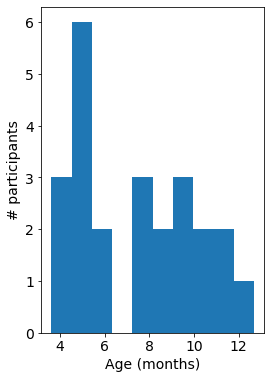

In [6]:
# Print the age

plt.figure(figsize=(4,6))
included_ages = df['age']
included_ages=np.array(included_ages,dtype=float)

plt.hist(included_ages, bins=10)
plt.xlabel('Age (months)',fontsize=14)
plt.ylabel('# participants',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(save_plot_dir+'age_hist.svg')

print('N=%d, (Female=%s) Mean age: %0.2f, (SD = %0.2f); min: %0.2f, max: %0.2f' % 
      (len(included_ages), sum(df.sex=='F'),included_ages.mean(), included_ages.std(), included_ages.min(), included_ages.max()))

In [7]:
session_num=[]
for sub in df.ppt:
    session_num.append(int(sub.split('_')[2]))
print('On what session was the movie data was collected')
print('Session 1:',sum(np.array(session_num)==1))
print('Session 2:',sum(np.array(session_num)==2))
print('Session 3+',sum(np.array(session_num)>2))

On what session was the movie data was collected
Session 1: 13
Session 2: 5
Session 3+ 6


In [8]:
print('Num coders: M= %f SD = %f' % (np.nanmean(df.coder_num),np.nanstd(df.coder_num)))

Num coders: M= 2.166667 SD = 0.623610


In [9]:
print('Mean Reliability: M= %f SD = %f; range: %f -- %f' %(
    np.nanmean(df.eye_reliability),np.nanstd(df.eye_reliability),np.nanmin(df.eye_reliability),np.nanmax(df.eye_reliability)))

Mean Reliability: M= 0.932008 SD = 0.051658; range: 0.777226 -- 0.996211


In [10]:
print('Mean TRs included for motion: M= %f SD = %f; range: %f -- %f' %(
    np.nanmean(df.prop_TR_motion),np.nanstd(df.prop_TR_motion),np.nanmin(df.prop_TR_motion),np.nanmax(df.prop_TR_motion)))

print('Mean TRs included for eye: M= %f SD = %f; range: %f -- %f' %(
    np.nanmean(df.prop_TR_eye),np.nanstd(df.prop_TR_eye),np.nanmin(df.prop_TR_eye),np.nanmax(df.prop_TR_eye)))

Mean TRs included for motion: M= 0.925852 SD = 0.099470; range: 0.655556 -- 1.000000
Mean TRs included for eye: M= 0.884003 SD = 0.121770; range: 0.555556 -- 1.000000


Adult participants

In [11]:
# Load in the data
df_adult = pd.read_csv(movie_eventseg_dir + '/adult_participants.csv')
df_adult

,ppt,age,sex,location,session_number,num_TR,prop_TR_motion,prop_TR_eye,eye_reliability,coder_num
0,mov_01,20.0,F,BIC,1,90,1.0,0.988889,NaN,1
1,mov_02,20.0,F,BIC,1,90,1.0,1.000000,NaN,1
2,mov_03,19.0,F,BIC,1,90,1.0,0.944444,NaN,1
3,mov_04,21.0,F,BIC,1,90,1.0,1.000000,NaN,1
4,mov_05,21.0,M,BIC,1,90,1.0,1.000000,NaN,1
5,mov_06,18.0,F,BIC,1,90,1.0,0.988889,NaN,1
6,mov_07,23.0,M,BIC,1,90,1.0,1.000000,NaN,1
7,mov_08,21.0,M,BIC,1,90,1.0,1.000000,NaN,1
8,mov_09,22.0,M,BIC,1,90,1.0,0.988889,NaN,1
9,mov_10,23.0,F,BIC,1,90,1.0,1.000000,NaN,1


In [12]:
print(df_adult.to_latex())

\begin{tabular}{llrllrrrrrr}
\toprule
{} &     ppt &   age & sex & location &  session\_number &  num\_TR &  prop\_TR\_motion &  prop\_TR\_eye &  eye\_reliability &  coder\_num \\
\midrule
0  &  mov\_01 &  20.0 &   F &      BIC &               1 &      90 &             1.0 &     0.988889 &              NaN &          1 \\
1  &  mov\_02 &  20.0 &   F &      BIC &               1 &      90 &             1.0 &     1.000000 &              NaN &          1 \\
2  &  mov\_03 &  19.0 &   F &      BIC &               1 &      90 &             1.0 &     0.944444 &              NaN &          1 \\
3  &  mov\_04 &  21.0 &   F &      BIC &               1 &      90 &             1.0 &     1.000000 &              NaN &          1 \\
4  &  mov\_05 &  21.0 &   M &      BIC &               1 &      90 &             1.0 &     1.000000 &              NaN &          1 \\
5  &  mov\_06 &  18.0 &   F &      BIC &               1 &      90 &             1.0 &     0.988889 &              NaN &          1 \\
6

N=24, (Female=13) Mean age: 22.54, (SD = 3.66); min: 18.00, max: 32.00


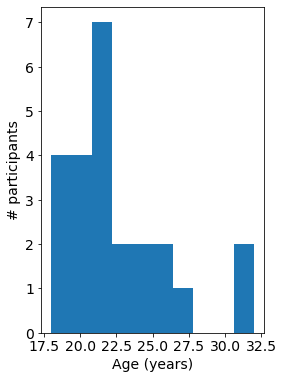

In [13]:
# Print the age
plt.figure(figsize=(4,6))
included_ages_adults = df_adult['age']
included_ages_adults=np.array(included_ages_adults,dtype=float)

plt.hist(included_ages_adults, bins=10)
plt.xlabel('Age (years)',fontsize=14)
plt.ylabel('# participants',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(save_plot_dir+'adult_age_hist.svg')

print('N=%d, (Female=%s) Mean age: %0.2f, (SD = %0.2f); min: %0.2f, max: %0.2f' % 
      (len(included_ages_adults), sum(df_adult.sex=='F'),included_ages_adults.mean(), 
       included_ages_adults.std(), included_ages_adults.min(), included_ages_adults.max()))

In [14]:
print('Mean TRs included for motion: M= %f SD = %f; range: %f -- %f' %(
    np.nanmean(df_adult.prop_TR_motion),np.nanstd(df_adult.prop_TR_motion),np.nanmin(df_adult.prop_TR_motion),np.nanmax(df_adult.prop_TR_motion)))

print('Mean TRs included for eye: M= %f SD = %f; range: %f -- %f' %(
    np.nanmean(df_adult.prop_TR_eye),np.nanstd(df_adult.prop_TR_eye),np.nanmin(df_adult.prop_TR_eye),np.nanmax(df_adult.prop_TR_eye)))

Mean TRs included for motion: M= 1.000000 SD = 0.000000; range: 1.000000 -- 1.000000
Mean TRs included for eye: M= 0.987963 SD = 0.032222; range: 0.844444 -- 1.000000


## Create input data <a id='preproc'></a>

**NOTE: this section requires downloading preprocessed data or running the analysis pipeline for movie-watching on raw data. It is optional and does not need to run since the numpy files it creates are available in the event segmentation data folder**

Take in preprocessed fMRI data aligned to standard space, shift the data, remove motion and eye tracking exclusion TRs. For the Mickey dataset, fMRI data across two viewings is averaged. This creates a numpy file that can be loaded in for other analyses.

In [15]:
if os.path.isfile(movie_eventseg_dir+'infants_wholebrain_data.npy') == False:
    print('Creating preprocessed infant data')
    
    infant_data=[]

    for sub in df.ppt:
        brain_masked=preprocess_data(sub,average_halves)
        infant_data.append(brain_masked)

    infants_stacked_data=np.dstack(infant_data) 
    
    # Save as a numpy file (nTRs x nVox x nSubj) 
    np.save(movie_eventseg_dir+'infants_wholebrain_data.npy',infants_stacked_data)
    
else:
    print('Loading existing infant data')
    
    # Load in the preprocessed subject data (nTRs x nVox x nSubj)
    infants_stacked_data=np.load(movie_eventseg_dir+'infants_wholebrain_data.npy')
    print('Shape of data:',infants_stacked_data.shape)

Loading existing infant data
Shape of data: (90, 51729, 24)


In [16]:
if os.path.isfile(movie_eventseg_dir+'adults_wholebrain_data.npy') == False:
    print('Creating preprocessed adult data')
    
    adult_data=[]

    for sub in df_adult.ppt:
        brain_masked=preprocess_data(sub,average_halves)
        adult_data.append(brain_masked)
    
    adults_stacked_data=np.dstack(adult_data)
    
    # Save as a numpy file (nTRs x nVox x nSubj) 
    np.save(movie_eventseg_dir+'adults_wholebrain_data.npy',adults_stacked_data)
    
else:
    print('Loading existing adult data')
    
    # Load in the preprocessed subject data (nTRs x nVox x nSubj)
    adults_stacked_data=np.load(movie_eventseg_dir+'adults_wholebrain_data.npy')
    print('Shape of data:',adults_stacked_data.shape)

Loading existing adult data
Shape of data: (90, 51729, 24)


## Intersubject correlation analyses <a id='isc'></a>

Perform intersubject correlation analysis for every voxel in the brain

In [17]:
# Run ISC! (might take a second to run)
# infants
intersubjectcorr_infants=isc(infants_stacked_data)

infant_mean_isc=compute_summary_statistic(intersubjectcorr_infants, summary_statistic='mean', axis=0)
infant_mean_isc_nii=brain_masker.inverse_transform(infant_mean_isc)

# adults
intersubjectcorr_adults=isc(adults_stacked_data,tolerate_nans=True)

adult_mean_isc=compute_summary_statistic(intersubjectcorr_adults, summary_statistic='mean', axis=0)
adult_mean_isc_nii=brain_masker.inverse_transform(adult_mean_isc)

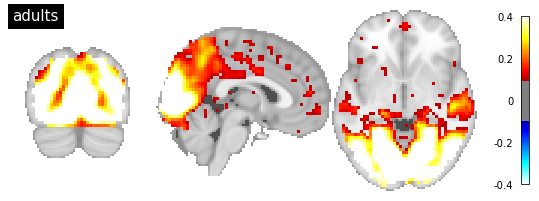

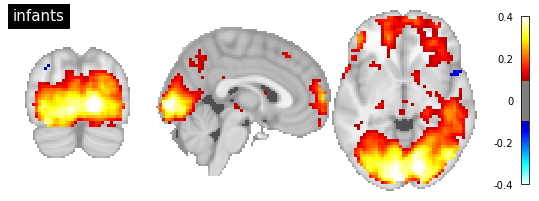

In [18]:
# View the data

one=plotting.plot_stat_map(adult_mean_isc_nii,threshold=isc_thresh, title='adults',
                           vmax=vmax,cmap=cmap,cut_coords=cut_coords,draw_cross=False,annotate=False)
two=plotting.plot_stat_map(infant_mean_isc_nii,threshold=isc_thresh, title='infants',
                       vmax=vmax,cmap=cmap,cut_coords=cut_coords,draw_cross=False,annotate=False)

one.savefig(save_plot_dir + 'isc_adults.svg')
two.savefig(save_plot_dir + 'isc_infants.svg')

Visualize ISC values across different ROIs

In [19]:
# Now lets average the ISC values across rois 
ages=['adults','infants']

adult_roi_iscs=[]
infant_roi_iscs=[]
    
for age in ages:
    
    if age =='infants':
        iscs=intersubjectcorr_infants
    else:
        iscs=intersubjectcorr_adults

    for roi in rois:

        roi_iscs=[]
        for sub in range(len(iscs)):
            
            roi_nii=nib.load(roi_dir+roi+'.nii.gz')

            sub_nii=brain_masker.inverse_transform(iscs[sub])

            sub_data=sub_nii.get_data()[np.array(brain_nii.get_data()*roi_nii.get_data(),dtype=bool)]

            roi_iscs.append(np.tanh(np.nanmean(np.arctanh(sub_data))))
            
        if age=='adults':
            adult_roi_iscs.append(np.array(roi_iscs))
        else:
            infant_roi_iscs.append(np.array(roi_iscs))

In [20]:
isc_roi_df=pd.DataFrame({'adults':adult_roi_iscs,'infants':infant_roi_iscs},index=rois)
isc_roi_df

,adults,infants
EVC_standard,"[0.45899493, 0.46503025, 0.32612082, 0.5848161...","[0.48652506, 0.45789558, 0.24798691, 0.4823664..."
LOC_standard,"[0.44961032, 0.3757677, 0.34282652, 0.49700308...","[0.34041813, 0.27413, 0.2800772, 0.3999497, 0...."
AG_standard,"[0.067290284, 0.07119431, 0.16454516, -0.05019...","[-0.076976255, -0.09481999, -0.04886032, 0.374..."
PCC_standard,"[0.10896787, 0.044540755, 0.16477877, 0.116923...","[0.07565676, 0.09483587, -0.07600216, 0.482500..."
Precuneus_standard,"[0.11345166, 0.06655228, 0.20155334, 0.1453522...","[0.038794942, 0.08386936, -0.060068917, 0.2423..."
mPFC_standard,"[0.103110425, 0.038101744, 0.08417336, 0.07662...","[0.14325243, 0.1564311, -0.20675546, 0.1860812..."
Hippocampus_standard,"[0.024753453, 0.008561762, 0.03425502, 0.06399...","[0.15202582, -0.10935722, -0.097718455, 0.1024..."
EAC_standard,"[0.070814654, 0.1266794, 0.023770534, 0.153254...","[-0.045639098, 0.030417686, -0.24942727, 0.132..."


adults
EVC_standard : 0.498 (0.446 -- 0.541), p = 0.001
LOC_standard : 0.430 (0.391 -- 0.466), p = 0.001
AG_standard : 0.094 (0.058 -- 0.127), p = 0.001
PCC_standard : 0.143 (0.097 -- 0.190), p = 0.001
Precuneus_standard : 0.160 (0.128 -- 0.193), p = 0.001
mPFC_standard : 0.053 (0.032 -- 0.077), p = 0.001
Hippocampus_standard : 0.047 (0.032 -- 0.062), p = 0.001
EAC_standard : 0.081 (0.044 -- 0.115), p = 0.001

infants
EVC_standard : 0.290 (0.197 -- 0.379), p = 0.001
LOC_standard : 0.206 (0.135 -- 0.275), p = 0.001
AG_standard : 0.079 (0.030 -- 0.133), p = 0.002
PCC_standard : 0.087 (0.028 -- 0.154), p = 0.006
Precuneus_standard : 0.073 (0.030 -- 0.118), p = 0.001
mPFC_standard : 0.073 (0.017 -- 0.124), p = 0.009
Hippocampus_standard : 0.059 (0.012 -- 0.113), p = 0.023
EAC_standard : 0.013 (-0.018 -- 0.039), p = 0.350


ISC difference in adults and infants
EVC_standard : 0.208, p = 0.001
LOC_standard : 0.224, p = 0.001
AG_standard : 0.015, p = 0.655
PCC_standard : 0.056, p = 0.137
Precu

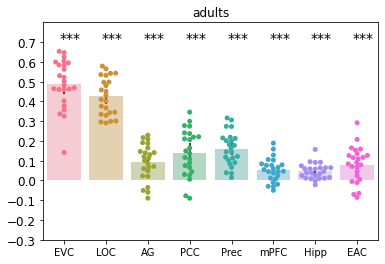

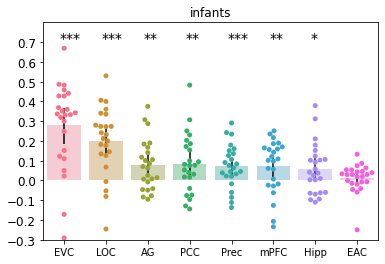

In [21]:
alpha=0.4
nPerm=1000

np.random.seed(0)
for age in ages:
    
    print(age)

    plt.figure()
    
    errors=np.zeros((2,len(rois)))
    for r, roi in enumerate(rois):  
        # Bootstrap! 
        avg_iscs=np.array(isc_roi_df[age][roi]).reshape(-1,1) # reshape for the function
        ob, ci, pval, boot_distribution=bootstrap_isc(avg_iscs,summary_statistic='mean',random_state=10)
        errors[0,r]=np.abs(ob-ci[0])
        errors[1,r]=np.abs(ob-ci[1])

        print('%s : %0.3f (%0.3f -- %0.3f), p = %0.3f' %(roi,ob, ci[0],ci[1],pval))
        
        draw_sig(pval[0],1,r-0.1,0.7)
        
    sns.barplot(data=isc_roi_df[age].T,palette=colors,alpha=alpha,ci=None)
    sns.swarmplot(data=isc_roi_df[age].T,palette=colors)
    plt.errorbar(np.arange(np.stack(isc_roi_df[age]).shape[0]),
             np.nanmean(np.stack(isc_roi_df[age]),axis=1),yerr=errors,fmt='none',ecolor='k') #use our CI
    plt.xticks(ticks=np.arange(len(roi_short)),labels=roi_short)

    plt.yticks(fontsize=12,ticks=np.arange(-0.3,0.8,0.1))
    plt.ylim(-0.3,0.8)
    plt.title(age)
    

    plt.savefig(save_plot_dir+'%s_roi_iscs.svg' %(age))
    print()

print()
print('ISC difference in adults and infants')
for roi in rois:
    
    ob, pval, perm_distribution=permutation_isc(np.hstack((isc_roi_df['adults'][roi],isc_roi_df['infants'][roi])).reshape(-1,1),
                                                    group_assignment=np.hstack((np.zeros(isc_roi_df['adults'][0].shape[0]),
                                                                                np.ones(isc_roi_df['infants'][0].shape[0]))).tolist(),
                                                    summary_statistic='mean',random_state=10)
    
    perm_CIs =[np.percentile(perm_distribution, 2.5), np.percentile(perm_distribution, 97.5)]
    
    print('%s : %0.3f, p = %0.3f' %(roi,ob,pval))
    
    
    

In [22]:
np.random.seed(0)

isc_values_all=isc_roi_df['infants']
    
for r, roi in enumerate(rois):
    data_roi=isc_values_all[r]  
    
    actual_corr=stats.pearsonr(included_ages,data_roi)[0]
    pval, _=bootstrap_corr(included_ages,data_roi,nPerm=1000)
    
    print('%s; correlation of infant age and ISC: %0.3f, p = %0.3f' %(roi,actual_corr,pval))
                                                                                

EVC_standard; correlation of infant age and ISC: 0.045, p = 0.908
LOC_standard; correlation of infant age and ISC: 0.020, p = 0.978
AG_standard; correlation of infant age and ISC: -0.245, p = 0.224
PCC_standard; correlation of infant age and ISC: -0.151, p = 0.428
Precuneus_standard; correlation of infant age and ISC: -0.112, p = 0.568
mPFC_standard; correlation of infant age and ISC: -0.158, p = 0.452
Hippocampus_standard; correlation of infant age and ISC: -0.422, p = 0.018
EAC_standard; correlation of infant age and ISC: -0.296, p = 0.120


In [23]:
np.random.seed(0)

isc_values_all=isc_roi_df['infants']
    
for r, roi in enumerate(rois):
    data_roi=isc_values_all[r]  
    
    actual_corr=stats.pearsonr(df.prop_TR_motion,data_roi)[0]
    pval, _=bootstrap_corr(df.prop_TR_motion,data_roi,nPerm=1000)
    
    print('%s; correlation of # TRs included for motion and ISC: %0.3f, p = %0.3f' %(roi,actual_corr,pval))
    
    actual_corr=stats.pearsonr(df.prop_TR_eye[~np.isnan(df.prop_TR_eye)],data_roi[~np.isnan(df.prop_TR_eye)])[0]
    pval, _=bootstrap_corr(df.prop_TR_eye[~np.isnan(df.prop_TR_eye)],data_roi[~np.isnan(df.prop_TR_eye)],nPerm=1000)
    
    print('%s; correlation of # TRs included for eyes and ISC: %0.3f, p = %0.3f' %(roi,actual_corr,pval))
    
    print()

EVC_standard; correlation of # TRs included for motion and ISC: 0.686, p = 0.002
EVC_standard; correlation of # TRs included for eyes and ISC: 0.399, p = 0.100

LOC_standard; correlation of # TRs included for motion and ISC: 0.516, p = 0.056
LOC_standard; correlation of # TRs included for eyes and ISC: 0.241, p = 0.414

AG_standard; correlation of # TRs included for motion and ISC: 0.033, p = 0.914
AG_standard; correlation of # TRs included for eyes and ISC: -0.092, p = 0.594

PCC_standard; correlation of # TRs included for motion and ISC: 0.153, p = 0.502
PCC_standard; correlation of # TRs included for eyes and ISC: 0.047, p = 0.824

Precuneus_standard; correlation of # TRs included for motion and ISC: 0.020, p = 0.938
Precuneus_standard; correlation of # TRs included for eyes and ISC: 0.017, p = 0.904

mPFC_standard; correlation of # TRs included for motion and ISC: 0.425, p = 0.172
mPFC_standard; correlation of # TRs included for eyes and ISC: 0.362, p = 0.128

Hippocampus_standard;

## Optimal number of events <a id='optimalk'></a>

Visualize the optimal number of events found using a searchlight over the whole brain.  
The files that are loaded in here are created by `FindOptK_Searchlight.py`

In [24]:
# May take a second to run 

# Loads in the different inner loop iterations and finds the optimal number of events across voxels
bestk_adults=searchlight_optk_data('adults',nSubj,num_events,split=2)
adults_k_nii=brain_masker.inverse_transform(bestk_adults)

bestk_infants=searchlight_optk_data('infants',nSubj,num_events,split=2)
infants_k_nii=brain_masker.inverse_transform(bestk_infants)

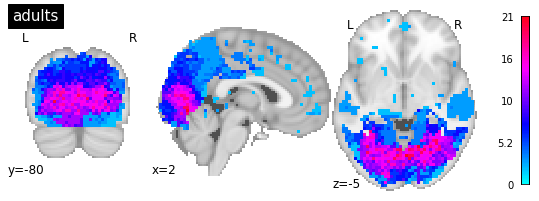

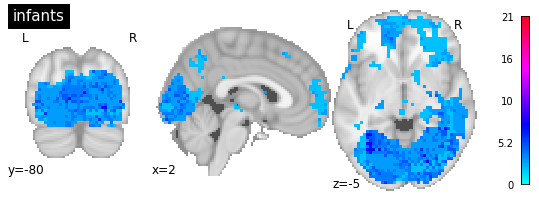

In [25]:
# Mask this output by the ISC values 
adult_isc_mask=adult_mean_isc_nii.get_data()>=isc_thresh
infant_isc_mask=infant_mean_isc_nii.get_data()>=isc_thresh

temp_adults=adults_k_nii.get_data()*adult_isc_mask
temp_infants=infants_k_nii.get_data()*infant_isc_mask

adults_k_nii_masked=nib.Nifti1Image(temp_adults,affine_mat)
infants_k_nii_masked=nib.Nifti1Image(temp_infants,affine_mat)

# Plot the whole brain optimal k data (unmasked)

one=plotting.plot_stat_map(adults_k_nii_masked,cmap='hsv',vmax=np.max(num_events),title='adults',
                       draw_cross=False,cut_coords=cut_coords)
two=plotting.plot_stat_map(infants_k_nii_masked,cmap='hsv',vmax=np.max(num_events),title='infants',
                        draw_cross=False,cut_coords=cut_coords)

one.savefig(save_plot_dir + 'kvals_adults.svg')
two.savefig(save_plot_dir + 'kvals_infants.svg')

Visualize the optimal number of events found by running the event segmentation model on each ROI seperately.   
The optimal K values for different ROIs were discovered using `FindOptK_ROI.py`

In [26]:
ages=['adults','infants']

for age in ages:
    print(age)
    for roi in rois:
        bestk=get_bestk_roi(age,roi,num_events,split=2)
        print(roi,' best K:',bestk)
    print()

adults
EVC_standard  best K: 12
LOC_standard  best K: 10
AG_standard  best K: 3
PCC_standard  best K: 3
Precuneus_standard  best K: 6
mPFC_standard  best K: 4
Hippocampus_standard  best K: 2
EAC_standard  best K: 3

infants
EVC_standard  best K: 3
LOC_standard  best K: 3
AG_standard  best K: 3
PCC_standard  best K: 2
Precuneus_standard  best K: 2
mPFC_standard  best K: 2
Hippocampus_standard  best K: 2
EAC_standard  best K: 3



In [27]:
# Load in the ROI data
roi = 'EVC_standard'

adults_roi_data=mask_roi_data(adults_stacked_data,roi)
infants_roi_data=mask_roi_data(infants_stacked_data,roi)

EVC_standard bounds in adults
best K: 12
event boundaries: [ 4 12 21 28 38 43 49 56 67 79 85]
(in seconds in the movie: [  4  20  38  52  72  82  94 108 130 154 166] )
EVC_standard bounds in infants
best K: 3
event boundaries: [23 63]
(in seconds in the movie: [ 42 122] )


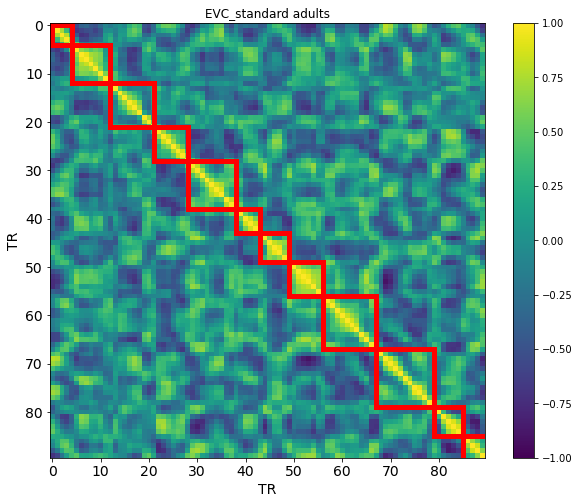

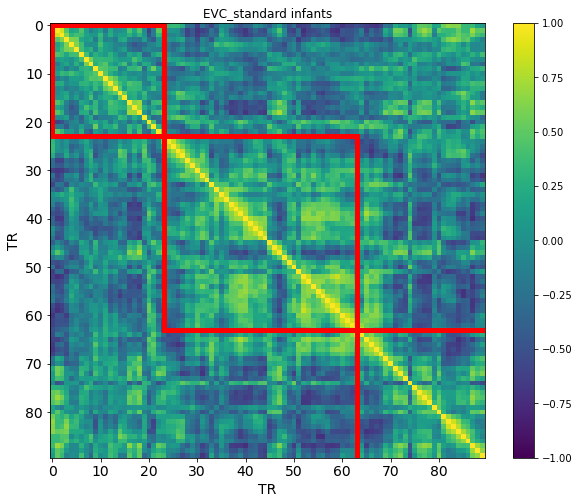

In [28]:
data=[adults_roi_data,infants_roi_data]

for idx, age in enumerate(ages):
    print('%s bounds in %s' %(roi,age))
    
    # load in the best k based on age and ROI
    bestk=get_bestk_roi(age,roi,num_events,split=2)
    print('best K:',bestk)
    
    # init the model 
    ev=EventSegment.EventSegment(np.int(bestk))
    
    # reshape the data to be subs x TRs x vox
    reshaped_data=data[idx].transpose(0,2,1)
    
    # get the mean representation
    train_mean=np.nanmean(reshaped_data,axis=0)

    # iterate through time points and figure out how many subjects have data at that time point
    subjects_with_data=np.zeros(reshaped_data.shape[1]) #preset
    for timepoint in range(reshaped_data.shape[1]):
        subjects_with_data[timepoint]=reshaped_data.shape[0]-sum(np.isnan(reshaped_data[:,timepoint,0])) 

    # run the model
    modeloutput=ev.fit(subjects_with_data,train_mean)
    
    # where are the event boundaries?
    bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
   
    # calculate the correlation matrix 
    rsa=np.corrcoef(train_mean)
    
    # visualize the time point by timepoint correlations with the boundaries imposed over top
    fig=plt.figure(figsize=(10,8))
    plt.title('%s %s' %(roi,age))
    plt.xlabel('TR',fontsize=14)
    plt.ylabel('TR',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.imshow(rsa,vmin=-1,vmax=1)

    ax = plt.gca()
    plt.colorbar()

    aug = np.concatenate(([0],(bounds),[nTRs])) 
    print('event boundaries:',bounds)
    print('(in seconds in the movie:',bounds*2-4,')')
    for i in range(len(aug)-1):
        rect = patches.Rectangle((aug[i],aug[i]),aug[i+1]-aug[i],aug[i+1]-aug[i],
                                 linewidth=5,edgecolor='red',facecolor='none')
        ax.add_patch(rect)

    fig.savefig('%s/%s_rsa_%s.svg' %(save_plot_dir,roi,age))

    

In [29]:
# Load in the ROI data
roi = 'Precuneus_standard'

adults_roi_data=mask_roi_data(adults_stacked_data,roi)
infants_roi_data=mask_roi_data(infants_stacked_data,roi)

Precuneus_standard bounds in adults
best K: 6
event boundaries in: [13 30 46 58 79]
(in seconds: [ 22  56  88 112 154] )
Precuneus_standard bounds in infants
best K: 2
event boundaries in: [30]
(in seconds: [56] )


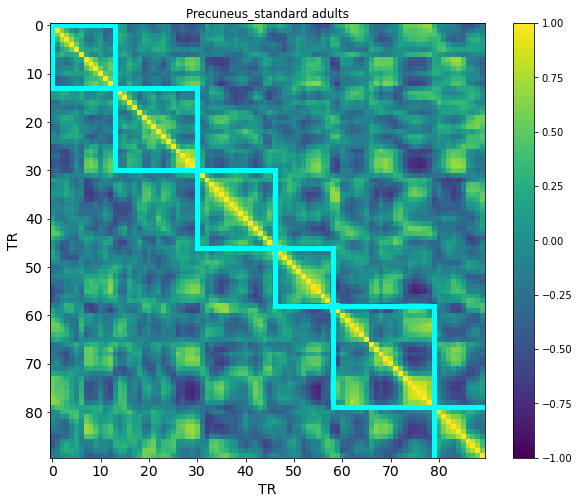

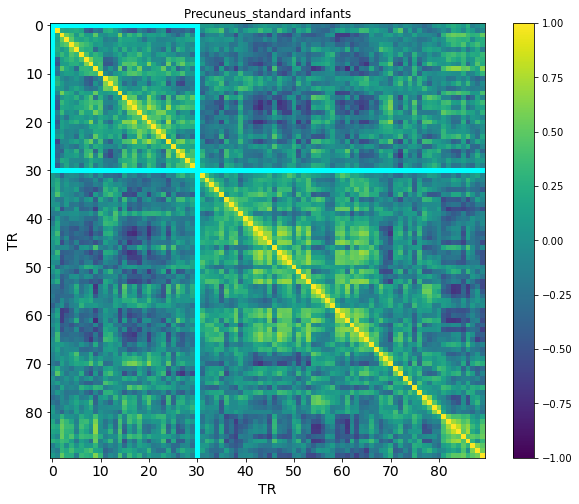

In [30]:
ages=['adults','infants']
data=[adults_roi_data,infants_roi_data]

for idx, age in enumerate(ages):
    print('%s bounds in %s' %(roi,age))
    
    # load in the best k based on age and ROI
    bestk=get_bestk_roi(age,roi,num_events,split=2)
    print('best K:',bestk)
    
    # init the model 
    ev=EventSegment.EventSegment(np.int(bestk))
    
    # reshape the data to be subs x TRs x vox
    reshaped_data=data[idx].transpose(0,2,1)
    
    # get the mean representation
    train_mean=np.nanmean(reshaped_data,axis=0)

    # iterate through time points and figure out how many subjects have data at that time point
    subjects_with_data=np.zeros(reshaped_data.shape[1]) #preset
    for timepoint in range(reshaped_data.shape[1]):
        subjects_with_data[timepoint]=reshaped_data.shape[0]-sum(np.isnan(reshaped_data[:,timepoint,0])) 

    # run the model
    modeloutput=ev.fit(subjects_with_data,train_mean)
    
    # where are the event boundaries?
    bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
    
    # calculate the correlation matrix 
    rsa=np.corrcoef(train_mean)
    
    # visualize the time point by timepoint correlations with the boundaries imposed over top
    fig=plt.figure(figsize=(10,8))
    plt.title('%s %s' %(roi,age))
    plt.xlabel('TR',fontsize=14)
    plt.ylabel('TR',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.imshow(rsa,vmin=-1,vmax=1)

    ax = plt.gca()
    plt.colorbar()

    aug = np.concatenate(([0],(bounds),[nTRs])) 
    print('event boundaries in:',bounds)
    print('(in seconds:',bounds*2-4,')')
    for i in range(len(aug)-1):
        rect = patches.Rectangle((aug[i],aug[i]),aug[i+1]-aug[i],aug[i+1]-aug[i],
                                 linewidth=5,edgecolor='aqua',facecolor='none')
        ax.add_patch(rect)

    fig.savefig('%s/%s_rsa_%s.svg' %(save_plot_dir,roi,age))

    

## Reliable event structure in ROIs <a id='nested'></a>

Visualize the reliability of event structure in different ROIs.   
The files that are loaded in here are created by running both the inner loop with `FindOptK_ROI.py` and the outer loop with `FindOptK_Outer.py`

adults
EVC_standard zstat vs perm: 4.849 (4.545 -- 5.155), p = 0.000
LOC_standard zstat vs perm: 5.531 (5.182 -- 5.855), p = 0.000
AG_standard zstat vs perm: 4.942 (4.383 -- 5.432), p = 0.000
PCC_standard zstat vs perm: 3.071 (2.274 -- 3.768), p = 0.000
Precuneus_standard zstat vs perm: 4.460 (4.021 -- 4.910), p = 0.000
mPFC_standard zstat vs perm: 3.228 (2.212 -- 4.199), p = 0.000
Hippocampus_standard zstat vs perm: 0.907 (0.147 -- 1.635), p = 0.014
EAC_standard zstat vs perm: 3.597 (3.059 -- 4.056), p = 0.000

infants
EVC_standard zstat vs perm: 3.888 (3.198 -- 4.570), p = 0.000
LOC_standard zstat vs perm: 4.868 (4.075 -- 5.620), p = 0.000
AG_standard zstat vs perm: 2.828 (2.147 -- 3.488), p = 0.000
PCC_standard zstat vs perm: 1.053 (0.394 -- 1.700), p = 0.002
Precuneus_standard zstat vs perm: 2.909 (1.807 -- 3.953), p = 0.000
mPFC_standard zstat vs perm: 2.079 (1.092 -- 3.065), p = 0.000
Hippocampus_standard zstat vs perm: 0.567 (0.006 -- 1.165), p = 0.046
EAC_standard zstat vs perm

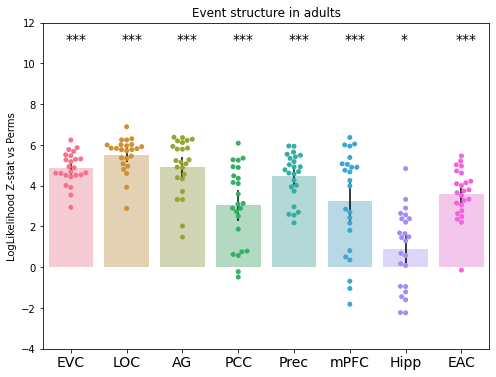

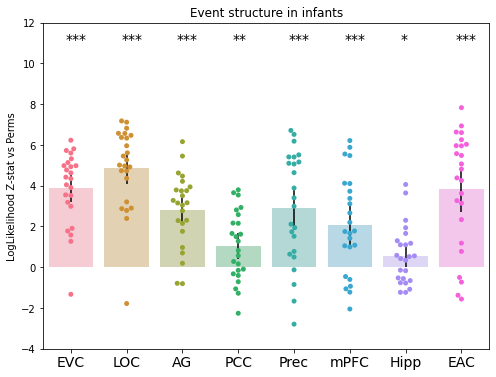

In [31]:
np.random.seed(0)

all_nested_errors=[]
for age in ages:
    print(age)
    
    fig=plt.figure(figsize=(8,6))

    zstat_values_all=[]
    errors=np.zeros((2,len(rois)))
    
    np.random.seed(0)
    for r, roi in enumerate(rois):
        
        chosen_ks,logliks,zstats=optk_results(optk_dir,age,roi,nSubj)
        zstat_values_all.append(zstats) # we care about the zstatistics 
        
        pval,CIs=bootstrap_mean(zstats,null_vall=0,nPerm=1000)
        errors[0,r]=np.abs(np.mean(zstats)-CIs[0])
        errors[1,r]=np.abs(np.mean(zstats)-CIs[1])
        print('%s zstat vs perm: %0.3f (%0.3f -- %0.3f), p = %0.3f' %(rois[r],np.mean(zstats), CIs[0],CIs[1],pval))
        
        draw_sig(pval,1,r-0.1,11)
     
    all_nested_errors.append(errors) # save for next plot for consistency
    
    np.save(optk_dir+'%s_nested_results.npy' %age,zstat_values_all) # save this 
    df=pd.DataFrame(zstat_values_all)
    
    plt.title('Event structure in %s' %(age))
    plt.ylabel('LogLikelihood Z-stat vs Perms')
    plt.ylim([-4,12])
    plt.yticks(fontsize=10)
    plt.xticks(ticks=np.arange(len(df.T.columns)),labels=roi_short,fontsize=14)
    
    sns.barplot(data=df.T,palette=colors,alpha=0.4, ci=None)
    plt.errorbar(np.arange(len(df.T.columns)),
             np.nanmean(np.array(df),axis=1),yerr=errors,fmt='none',ecolor='k') #use our CI
    sns.swarmplot(data=df.T,palette=colors)
    
    print()
    plt.xticks(ticks=np.arange(len(roi_short)),labels=roi_short)
    fig.savefig(save_plot_dir+'%s_nested_results.svg' % (age))

Relationship between model fit and age in infants

In [32]:
np.random.seed(0)

zstat_values_all=np.load(optk_dir+'%s_nested_results.npy' %'infants') # saved above but reload it here
    
for r, roi in enumerate(rois):
    data_roi=zstat_values_all[r,:]  

    actual_corr=stats.pearsonr(included_ages,data_roi)[0]

    pval, _=bootstrap_corr(included_ages,data_roi,nPerm=1000)
    
    print('%s; correlation of infant age and model fit: %0.3f (pval = %0.3f)' %(roi,actual_corr,pval))
                                                                                

EVC_standard; correlation of infant age and model fit: 0.061 (pval = 0.754)
LOC_standard; correlation of infant age and model fit: 0.194 (pval = 0.370)
AG_standard; correlation of infant age and model fit: 0.033 (pval = 0.872)
PCC_standard; correlation of infant age and model fit: -0.118 (pval = 0.534)
Precuneus_standard; correlation of infant age and model fit: 0.166 (pval = 0.386)
mPFC_standard; correlation of infant age and model fit: 0.014 (pval = 0.926)
Hippocampus_standard; correlation of infant age and model fit: 0.298 (pval = 0.098)
EAC_standard; correlation of infant age and model fit: 0.102 (pval = 0.652)


## Event structure across age groups <a id='across'></a>

Visualize the how event structure in one group relates to neural activity in another group.   
Some of the files that are loaded in here are created by running the script `Across_Group_Analysis.py`

In [33]:
adult_nested=np.load(optk_dir+'%s_nested_results.npy' %('adults'))
adult_bounds_infant=np.load(optk_dir+'%s_bounds_in_%s.npy' %('adults','infants'))

infant_nested=np.load(optk_dir+'%s_nested_results.npy' %('infants'))
infant_bounds_adult=np.load(optk_dir+'%s_bounds_in_%s.npy' %('infants','adults'))

In [34]:
all_data=np.hstack((adult_nested,adult_bounds_infant,infant_nested,infant_bounds_adult)).T
categories=np.hstack((np.zeros((adult_nested.shape[1])),np.ones((adult_bounds_infant.shape[1])),
                      2*np.ones((infant_nested.shape[1])),3*np.ones((infant_bounds_adult.shape[1]))))


rois_all=[]
data_all=[]
fit_group=[]
test_group=[]

for sub in range(all_data.shape[0]):
    for r in range(all_data.shape[1]):
        rois_all.append(roi_short[r])
        data_all.append(all_data[sub,r])
        
        if categories[sub] ==0:
            fit_group.append('adults')
            test_group.append('adults')
        elif categories[sub] ==1:
            fit_group.append('adults')
            test_group.append('infants')
        elif categories[sub] ==2:
            fit_group.append('infants')
            test_group.append('infants')
        elif categories[sub] ==3:
            fit_group.append('infants')
            test_group.append('adults')
            
df_all=pd.DataFrame({'Data':data_all,'Roi':rois_all,'Test':test_group,'Fit':fit_group})

EVC
adults - infants across group mean: M = 3.814 (3.395 - 4.262), p = 0.000 
infants - adults across group mean: M = 2.333 (1.725 - 2.893), p = 0.000 
adult event patterns in adults vs infants M = 1.035 (0.490 - 1.562), p = 0.000
infant event patterns in infants vs adults difference M = 1.555 (0.585 - 2.418), p = 0.006
LOC
adults - infants across group mean: M = 4.816 (4.303 - 5.293), p = 0.000 
infants - adults across group mean: M = 3.985 (3.142 - 4.809), p = 0.000 
adult event patterns in adults vs infants M = 0.715 (0.152 - 1.308), p = 0.012
infant event patterns in infants vs adults difference M = 0.884 (-0.242 - 2.094), p = 0.128
AG
adults - infants across group mean: M = 3.118 (2.453 - 3.719), p = 0.000 
infants - adults across group mean: M = 1.898 (1.078 - 2.753), p = 0.000 
adult event patterns in adults vs infants M = 1.824 (0.952 - 2.646), p = 0.000
infant event patterns in infants vs adults difference M = 0.930 (-0.281 - 2.106), p = 0.146
PCC
adults - infants across group

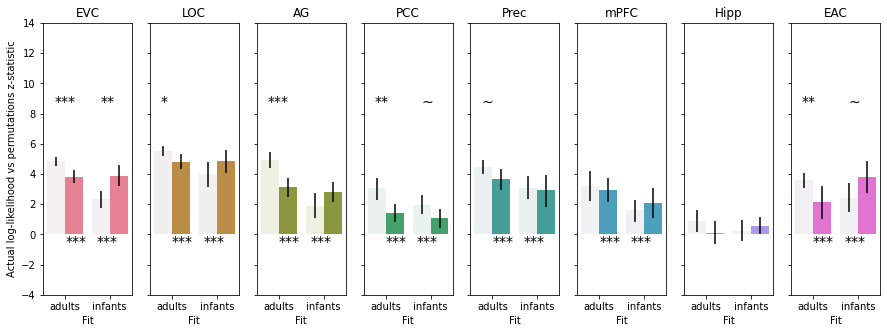

In [35]:
fig, ax = plt.subplots(1, len(rois), figsize=(15, 5), sharey=True)
ax[0].set_ylim(-4,14) # restrict range since we aren't plotting individual points
ax[0].set_xlim(-0.5,1.5)

np.random.seed(0)
for r, roi in enumerate(roi_short):
    
    idx=np.where(np.array(roi_short)==roi)[0][0]
    df=df_all[df_all.Roi==roi]

    bar=sns.barplot(ax=ax[r],x='Fit',y='Data',hue='Test',data=df,color=colors[idx],
                alpha=1,ci=False)
    
    ax[r].get_legend().remove() # remove the legend
    ax[r].set_ylabel('')
    ax[r].set_title(roi)
    
    print(roi)
    
    # Replot errors from previous figure
    errors=all_nested_errors[0][:,r]
    ax[r].errorbar([-0.2],np.nanmean(adult_nested[idx,:]),yerr=np.expand_dims(errors,1),fmt='none',ecolor='k')
    
    errors=all_nested_errors[1][:,r]
    ax[r].errorbar([1.2],np.nanmean(infant_nested[idx,:]),yerr=np.expand_dims(errors,1),fmt='none',ecolor='k')
    
    # Significance across group
    pval_1,ci1=bootstrap_mean(adult_bounds_infant[idx,:],null_vall=0,nPerm=1000)
    errors=np.array([np.abs(np.nanmean(adult_bounds_infant[idx,:])-ci1[0]),
            np.abs(np.nanmean(adult_bounds_infant[idx,:])-ci1[1])])
    ax[r].errorbar([0.2],np.nanmean(adult_bounds_infant[idx,:]),yerr=np.expand_dims(errors,1),fmt='none',ecolor='k')
    draw_sig(pval_1,1,0,-0.75,subplot=ax[r])
    print('adults - infants across group mean: M = %0.3f (%0.3f - %0.3f), p = %0.3f '%(np.nanmean(adult_bounds_infant[idx,:]),ci1[0],ci1[1],pval_1))

    pval_2,ci2=bootstrap_mean(infant_bounds_adult[idx,:],null_vall=0,nPerm=1000)
    errors2=np.array([np.abs(np.nanmean(infant_bounds_adult[idx,:])-ci2[0]),
            np.abs(np.nanmean(infant_bounds_adult[idx,:])-ci2[1])])
    ax[r].errorbar([0.8],np.nanmean(infant_bounds_adult[idx,:]),yerr=np.expand_dims(errors2,1),fmt='none',ecolor='k')
    draw_sig(pval_2,1,0.7,-0.75,subplot=ax[r])
    print('infants - adults across group mean: M = %0.3f (%0.3f - %0.3f), p = %0.3f '%(np.nanmean(infant_bounds_adult[idx,:]),ci2[0],ci2[1],pval_2))
    
    # Significance difference
    pval_int,meandiff,ci_int=randomise_diff_2sample(adult_nested[idx,:], adult_bounds_infant[idx,:], resample_num=1000)
    draw_sig(pval_int,1,-0.25,8.5,subplot=ax[r])
    print('adult event patterns in adults vs infants M = %0.3f (%0.3f - %0.3f), p = %0.3f'%(meandiff,ci_int[0],ci_int[1],pval_int))

    pval_int,meandiff,ci_int=randomise_diff_2sample(infant_nested[idx,:], infant_bounds_adult[idx,:], resample_num=1000)
    draw_sig(pval_int,1,0.8,8.5,subplot=ax[r])
    print('infant event patterns in infants vs adults difference M = %0.3f (%0.3f - %0.3f), p = %0.3f'%(meandiff,ci_int[0],ci_int[1],pval_int))

ax[0].set_ylabel('Actual log-likelihood vs permutations z-statistic')    
fig.savefig(save_plot_dir+'across_groups_ll_all_rois.svg')

Relationship between adult boundary fit and infant age

In [36]:
np.random.seed(0)

for r, roi in enumerate(rois):
    data_roi=adult_bounds_infant[r,:]  

    actual_corr=stats.pearsonr(included_ages,data_roi)[0]

    pval, _=bootstrap_corr(included_ages,data_roi,nPerm=1000)
    print('%s; correlation of infant age and adult bounds LL: %0.3f, p = %0.3f' %(roi,actual_corr,pval))
                                                                                

EVC_standard; correlation of infant age and adult bounds LL: -0.001, p = 0.972
LOC_standard; correlation of infant age and adult bounds LL: 0.457, p = 0.026
AG_standard; correlation of infant age and adult bounds LL: 0.217, p = 0.254
PCC_standard; correlation of infant age and adult bounds LL: 0.128, p = 0.536
Precuneus_standard; correlation of infant age and adult bounds LL: 0.003, p = 0.978
mPFC_standard; correlation of infant age and adult bounds LL: -0.107, p = 0.532
Hippocampus_standard; correlation of infant age and adult bounds LL: 0.105, p = 0.572
EAC_standard; correlation of infant age and adult bounds LL: -0.287, p = 0.160


## Behavioral boundary analyses <a id='behavbound'></a>

Visualize how fMRI activity corresponds to behavioral boundaries. ROI analyses are run in this notebook. The searchlight analysis is run with `HumanBounds_Searchlight.py` and z-statistic images were created with  `HumanBounds_Bootstrapping.py` 

NOTE: this will not work for the Mickey dataset, which did not have behavioral boundaries collected

In [37]:
bounds_TR, events_array=gethumanbounds()

keypress_timecourse_by_subs=np.load(movie_eventseg_dir+'behavioral_boundary_keypress_all_subjects.npy')
keypress_timecourse=np.load(movie_eventseg_dir+'behavioral_boundary_keypress.npy')

Time in TRs: [ 7 19 25 29 49 55 57 75 83 87]
Time in movie seconds: [ 12  36  48  56  96 108 112 148 164 172]


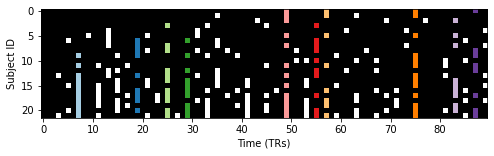

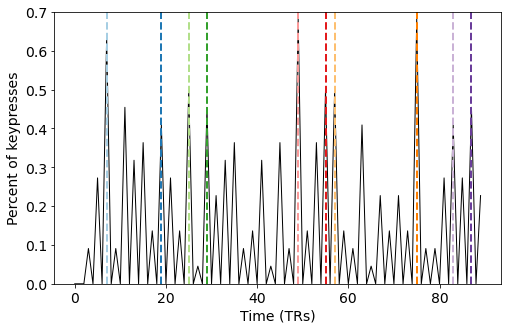

In [38]:

# First plot the individual subject responses, that are binned into 4-second intervals, remapped into TRs
# and color the time points that are designated as event boundaries
cmap = plt.cm.gray
norm = plt.Normalize(keypress_timecourse_by_subs.min(), keypress_timecourse_by_subs.max())
rgba = cmap(norm(keypress_timecourse_by_subs))

for e, ev in enumerate(bounds_TR):
    rgba[ev, keypress_timecourse_by_subs[ev]==1, :3] =  plt.cm.Paired.colors[e]

fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(rgba.transpose(1,0,2), interpolation='nearest')

ax.set_ylabel('Subject ID')
ax.set_xlabel('Time (TRs)')
fig.savefig(save_plot_dir+'behavioral_boundaries_subject_timecourse.svg')

# Another way of viewing the data -- timecourse of subject agreement
fig=plt.figure(figsize=(8,5))

plt.plot(keypress_timecourse/22,color='k',linewidth=1) # divide by the number of subjects in this experiment (22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (TRs)',fontsize=14)
plt.ylabel('Percent of keypresses',fontsize=14)
plt.ylim(0,0.7)

temp_colors=sns.color_palette('Paired',len(bounds_TR))

for e, ev in enumerate(bounds_TR):
    plt.axvline(ev,linestyle='dashed',color=temp_colors[e],linewidth=2)
    
print('Time in TRs:',bounds_TR)
print('Time in movie seconds:',(bounds_TR+1)*2-4) # multiply by TR length, subtract the HRF correction we used
fig.savefig(save_plot_dir+'behavioral_boundaries_timecourse.svg')

Whole brain analysis

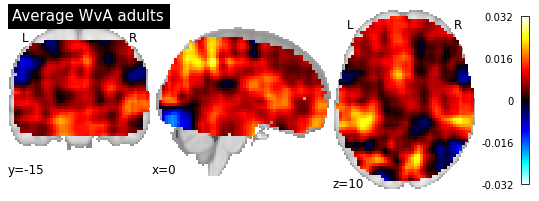

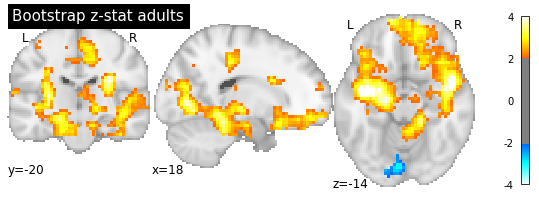

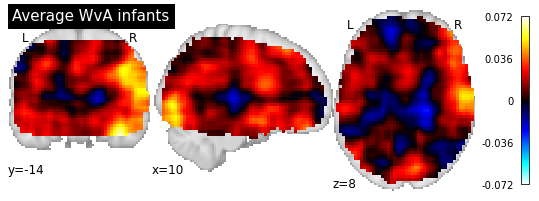

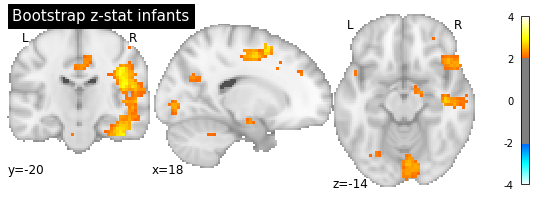

In [39]:
for age in ages:

    # load all of the individual subjects
    data_files=!ls {human_dir}/*{age}*sub*bounds.nii.gz

    # find the average
    brain_data=[]
    for file in data_files:
        nii=nib.load(file)
        data=brain_masker.fit_transform(nii)[0]
        brain_data.append(data)
    
    brain_data=np.stack(brain_data)
    avg_humanbound=np.nanmean(brain_data,axis=0)

    avg_nii=brain_masker.inverse_transform(avg_humanbound)
    
    # save this
    nib.save(avg_nii,human_dir+age+'_avg_bounds.nii.gz')

    # then load in the bootstrap z-stat image 
    z_nii=nib.load(human_dir+age+'_avg_zscores.nii.gz')
    
    # what is the p-value threshold for alpha
    pval_thresh=stats.t.ppf(1-0.025, nSubj) 

    cut_coords=(18,-20,-14) # choose different coordinates for this one
    
    # show the plot of the average 
    fig1=plotting.plot_stat_map(avg_nii,draw_cross=False, title='Average WvA %s' % age) #cut_coords=cut_coords)
    
    # show the plot of the z stat image
    fig2=plotting.plot_stat_map(z_nii,threshold=pval_thresh,draw_cross=False,
                            vmax=4,title='Bootstrap z-stat %s' % age,cut_coords=cut_coords)
    
    
    fig1.savefig(save_plot_dir + 'searchlight_wva_bounds_%s.svg' % age)
    fig2.savefig(save_plot_dir + 'searchlight_zstat_bounds_%s.svg' % age)


ROI analysis

adults
EVC_standard; M = -0.002 (-0.013 - 0.008), p = 0.622
LOC_standard; M = -0.011 (-0.022 - -0.001), p = 0.028
AG_standard; M = -0.003 (-0.025 - 0.018), p = 0.742
PCC_standard; M = -0.005 (-0.025 - 0.013), p = 0.602
Precuneus_standard; M = 0.024 (0.003 - 0.045), p = 0.024
mPFC_standard; M = 0.007 (-0.002 - 0.015), p = 0.108
Hippocampus_standard; M = 0.011 (0.004 - 0.018), p = 0.000
EAC_standard; M = 0.013 (0.004 - 0.022), p = 0.002

infants
EVC_standard; M = 0.027 (-0.007 - 0.068), p = 0.104
LOC_standard; M = -0.001 (-0.033 - 0.031), p = 0.894
AG_standard; M = 0.019 (-0.014 - 0.060), p = 0.306
PCC_standard; M = 0.021 (-0.003 - 0.049), p = 0.088
Precuneus_standard; M = 0.003 (-0.019 - 0.029), p = 0.878
mPFC_standard; M = 0.000 (-0.032 - 0.037), p = 0.994
Hippocampus_standard; M = 0.025 (-0.006 - 0.062), p = 0.144
EAC_standard; M = 0.030 (0.001 - 0.062), p = 0.044



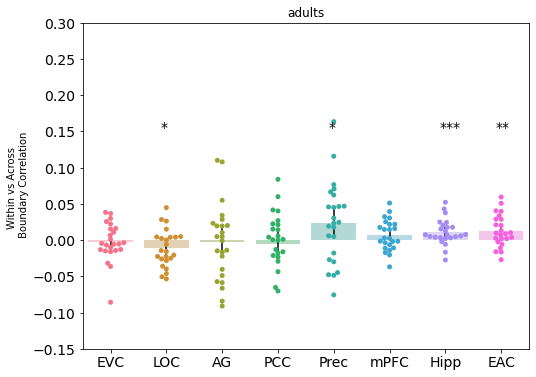

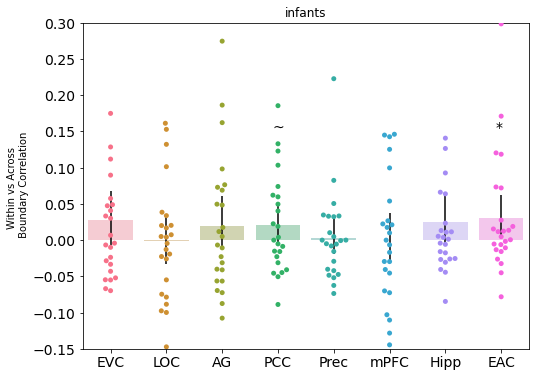

In [40]:
# this cell takes a second to run since there are some permutations to run 
np.random.seed(0)
temp=[]
for age in ages:
    
    print(age)
    if age == 'infants':
        stacked_data=infants_stacked_data
    else:
        stacked_data=adults_stacked_data
        
    roi_human_bound=[]
    errors=np.zeros((2,len(rois)))
    
    fig, ax =plt.subplots(figsize=(8,6))
    
    np.random.RandomState(0)
    for r, roi in enumerate(rois):

        roi_data=mask_roi_data(stacked_data,roi)

        _,wvas=human_boundary_analysis(roi_data)
        #wvas=human_boundary_analysis_alt(roi_data)

        roi_human_bound.append(wvas)
        
        pval,CIs=bootstrap_mean(wvas,null_vall=0,nPerm=1000)
        print('%s; M = %0.3f (%0.3f - %0.3f), p = %0.3f' % (roi,np.nanmean(wvas),CIs[0],CIs[1],pval))
        
        errors[0,r]=np.abs(np.mean(wvas)-CIs[0])
        errors[1,r]=np.abs(np.mean(wvas)-CIs[1])
        
        draw_sig(pval,1,r-0.1,0.15,subplot=ax)  
        
    print()
    data_wva=pd.DataFrame(roi_human_bound)
        
    sns.barplot(data=data_wva.T,palette=sns.color_palette("husl",len(rois)),alpha=0.4,ci=None)
    sns.swarmplot(data=data_wva.T,palette=sns.color_palette("husl",len(rois)))
    plt.errorbar(np.arange(len(data_wva.T.columns)),
             np.nanmean(np.array(data_wva),axis=1),yerr=errors,fmt='none',ecolor='k') #use our CI

    plt.title(age)
    plt.ylim([-0.15,0.3])
    plt.yticks(fontsize=14)
    plt.xticks(ticks=np.arange(8),labels=roi_short,fontsize=14)
    plt.ylabel('Within vs Across \n Boundary Correlation')

    fig.savefig(save_plot_dir+'%s_human_bounds_rois.svg' % age)
    
    temp.append(data_wva.T)

In [41]:
np.random.seed(0)

for r, roi in enumerate(rois):
    data_roi=np.array(roi_human_bound)[r,:]  # can use this because infants were analyzed after adults in the above cell
    
    actual_corr=stats.pearsonr(included_ages,data_roi)[0]

    pval, _=bootstrap_corr(included_ages,data_roi,nPerm=1000)
    
    print('%s; correlation of infant age and human boundary fit: %0.3f, p = %0.3f' %(roi,actual_corr,pval))

EVC_standard; correlation of infant age and human boundary fit: 0.077, p = 0.686
LOC_standard; correlation of infant age and human boundary fit: 0.149, p = 0.392
AG_standard; correlation of infant age and human boundary fit: 0.061, p = 0.798
PCC_standard; correlation of infant age and human boundary fit: 0.179, p = 0.304
Precuneus_standard; correlation of infant age and human boundary fit: 0.057, p = 0.732
mPFC_standard; correlation of infant age and human boundary fit: 0.253, p = 0.200
Hippocampus_standard; correlation of infant age and human boundary fit: 0.300, p = 0.062
EAC_standard; correlation of infant age and human boundary fit: 0.326, p = 0.036
